In [ ]:
connection without ssl
====================================

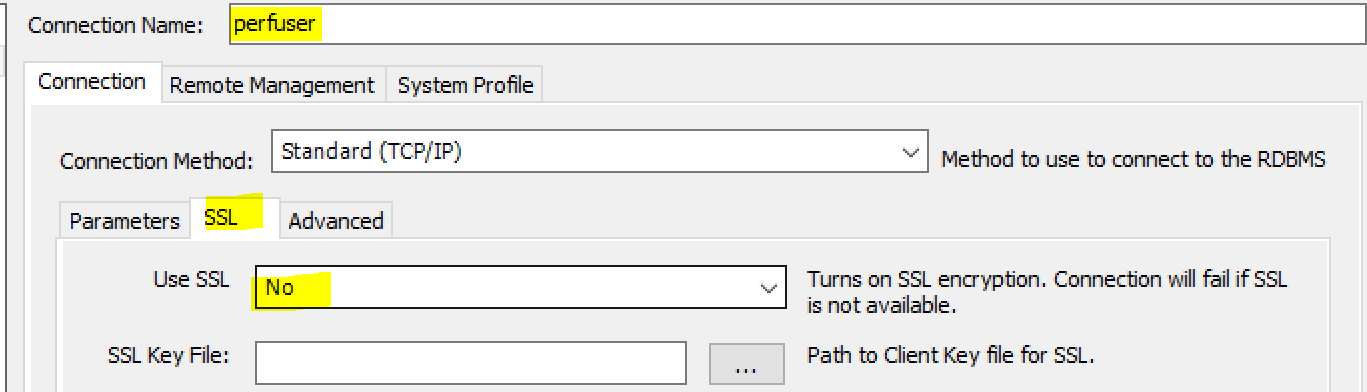

In [ ]:
mysql> select processlist_id , processlist_user , processlist_host , connection_type from 
performance_schema.threads where processlist_id is not null;
+----------------+------------------+------------------+-----------------+
| processlist_id | processlist_user | processlist_host | connection_type |
+----------------+------------------+------------------+-----------------+
|              5 | event_scheduler  | localhost        | NULL            |
|              7 | NULL             | NULL             | NULL            |
|              8 | root             | localhost        | Socket          |
|             16 | perfuser         | 192.168.153.1    | TCP/IP          |
|             17 | perfuser         | 192.168.153.1    | TCP/IP          |
+----------------+------------------+------------------+-----------------+
5 rows in set (0.00 sec)

In [ ]:
connection with ssl
===================================

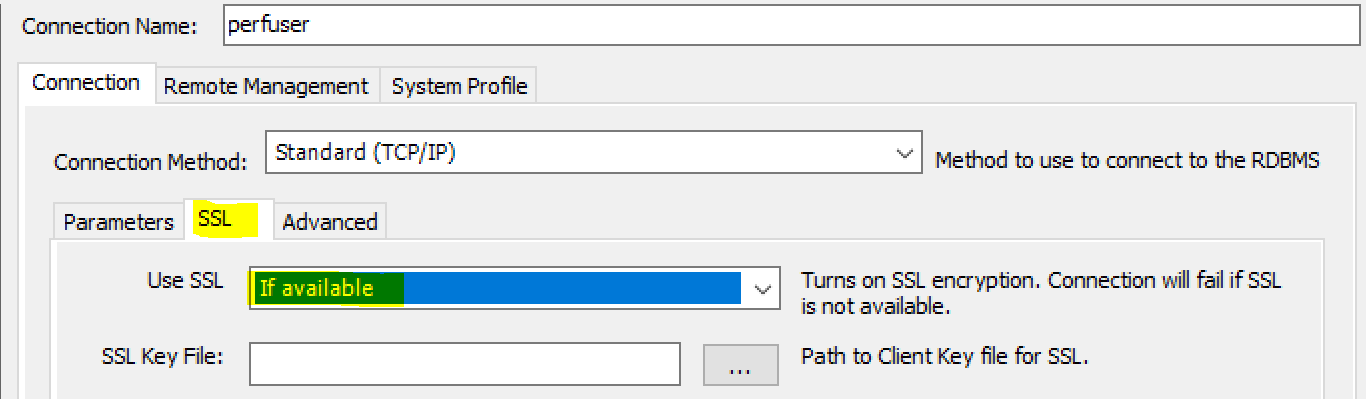

In [ ]:
mysql> select processlist_id , processlist_user , processlist_host , connection_type from 
performance_schema.threads where processlist_id is not null;
+----------------+------------------+------------------+-----------------+
| processlist_id | processlist_user | processlist_host | connection_type |
+----------------+------------------+------------------+-----------------+
|              5 | event_scheduler  | localhost        | NULL            |
|              7 | NULL             | NULL             | NULL            |
|              8 | root             | localhost        | Socket          |
|             18 | perfuser         | 192.168.153.1    | SSL/TLS         |
|             19 | perfuser         | 192.168.153.1    | SSL/TLS         |
+----------------+------------------+------------------+-----------------+
5 rows in set (0.01 sec)

In [ ]:
Add ssl server certificate path in the option file
==========================================================

In [ ]:

[root@bospprod01 ~]# cat /etc/my.cnf | grep ssl
ssl
ssl-cipher=DHE-RSA-AES256-SHA
ssl-ca=/var/lib/mysql/ca.pem
ssl-cert=/var/lib/mysql/server-cert.pem
ssl-key=/var/lib/mysql/server-key.pem
[root@bospprod01 ~]# 


[root@bospprod01 ~]# systemctl restart mysqld
[root@bospprod01 ~]# 


mysql> show variables like 'ssl_%';
+---------------------------+--------------------------------+
| Variable_name             | Value                          |
+---------------------------+--------------------------------+
| ssl_ca                    | /var/lib/mysql/ca.pem          |
| ssl_capath                |                                |
| ssl_cert                  | /var/lib/mysql/server-cert.pem |
| ssl_cipher                | DHE-RSA-AES256-SHA             |
| ssl_crl                   |                                |
| ssl_crlpath               |                                |
| ssl_fips_mode             | OFF                            |
| ssl_key                   | /var/lib/mysql/server-key.pem  |
| ssl_session_cache_mode    | ON                             |
| ssl_session_cache_timeout | 300                            |
+---------------------------+--------------------------------+
10 rows in set (0.00 sec)


In [ ]:
Force user to use ssl 
=====================================

In [ ]:
mysql> alter user perfuser require ssl;
Query OK, 0 rows affected (0.00 sec)

mysql> flush privileges;
Query OK, 0 rows affected (0.01 sec)

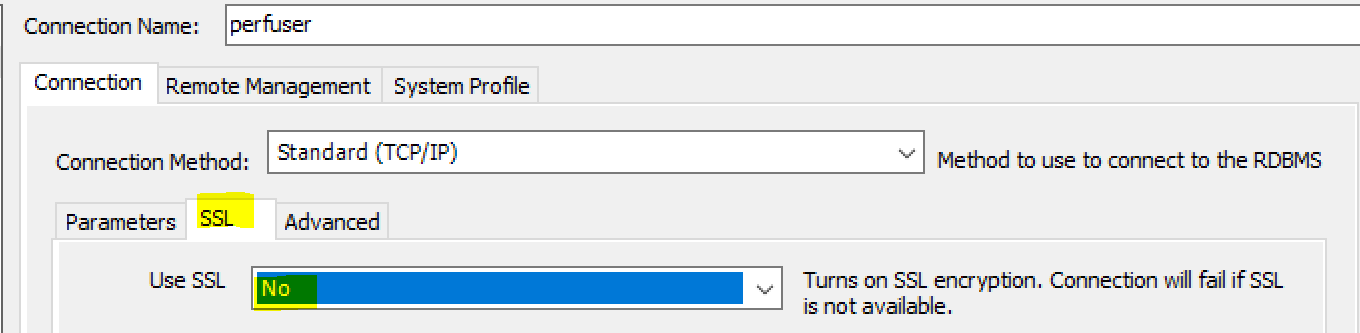

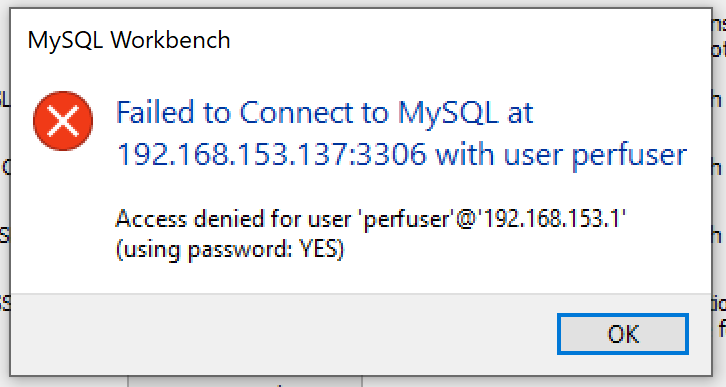

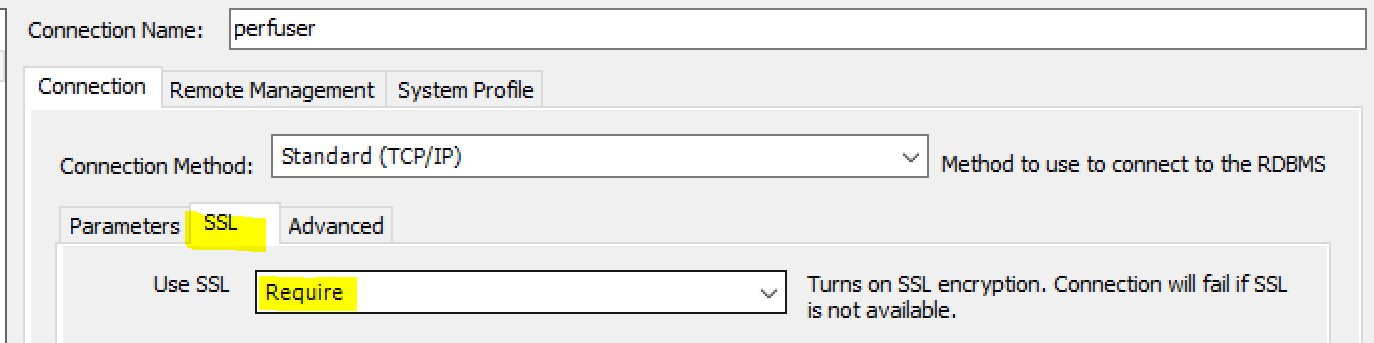

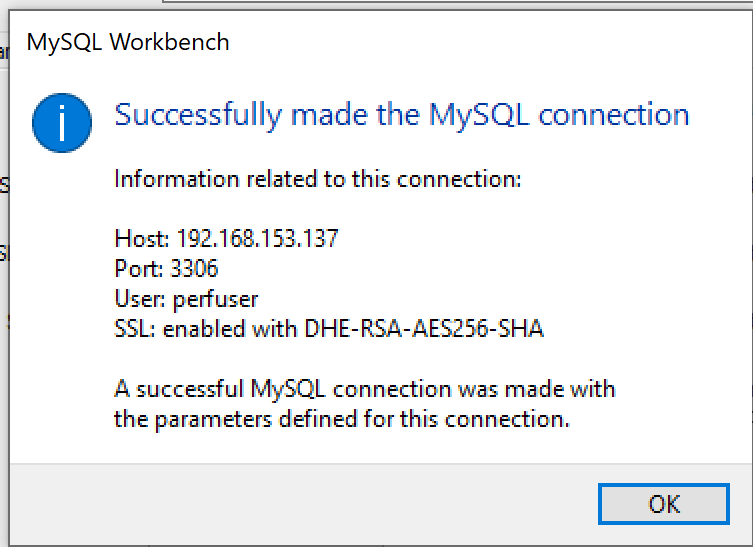

In [ ]:
Force user to use ca certificate
====================================================

In [ ]:
mysql> alter user perfuser require X509;
Query OK, 0 rows affected (0.00 sec)

mysql> flush privileges;
Query OK, 0 rows affected (0.00 sec)

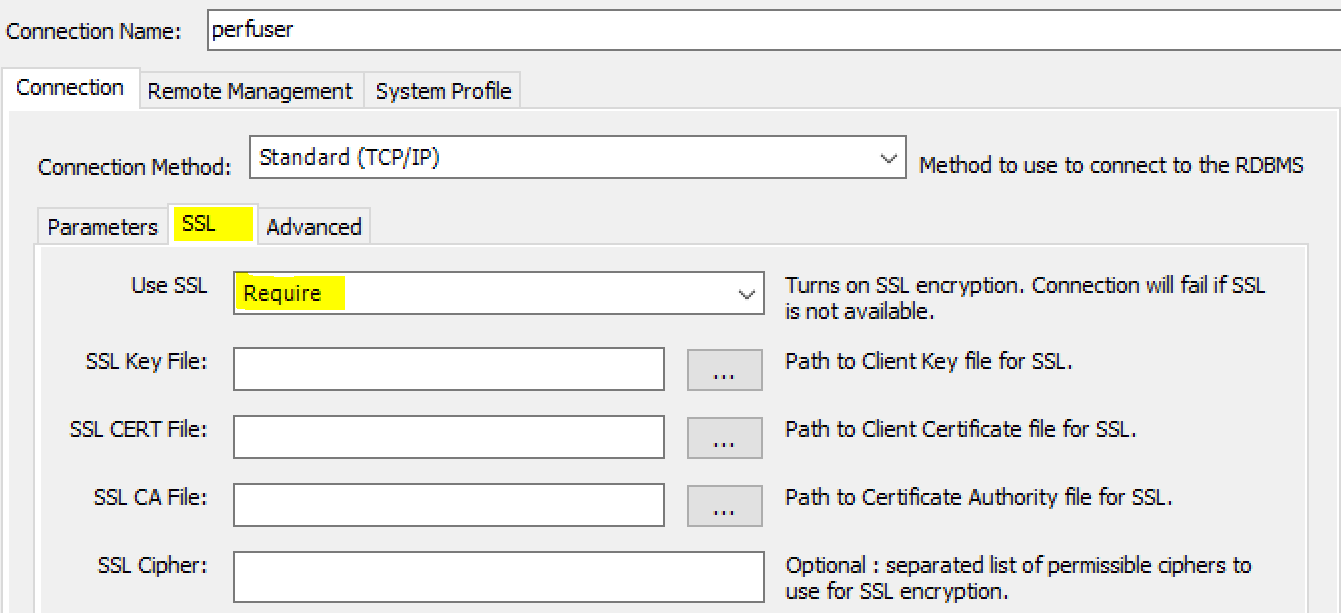

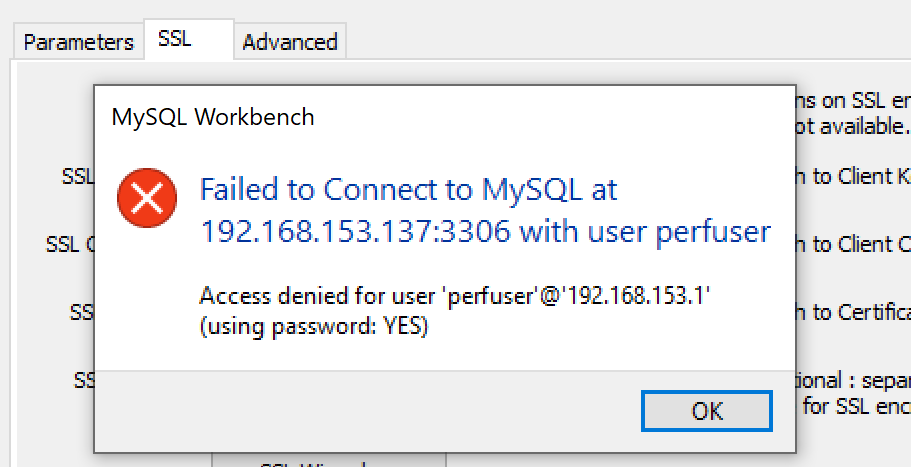

In [ ]:
copy the client certificate and key to windows host
====================================================================

In [ ]:
 C:\Users\Arvind>scp root@192.168.153.137:/var/lib/mysql/*client* .
 
root@192.168.153.137's password:
client-cert.pem                   100% 1112     1.1KB/s   00:00
client-key.pem                    100% 1680     1.6KB/s   00:00
ca.pem                            100% 1112     1.1KB/s   00:00

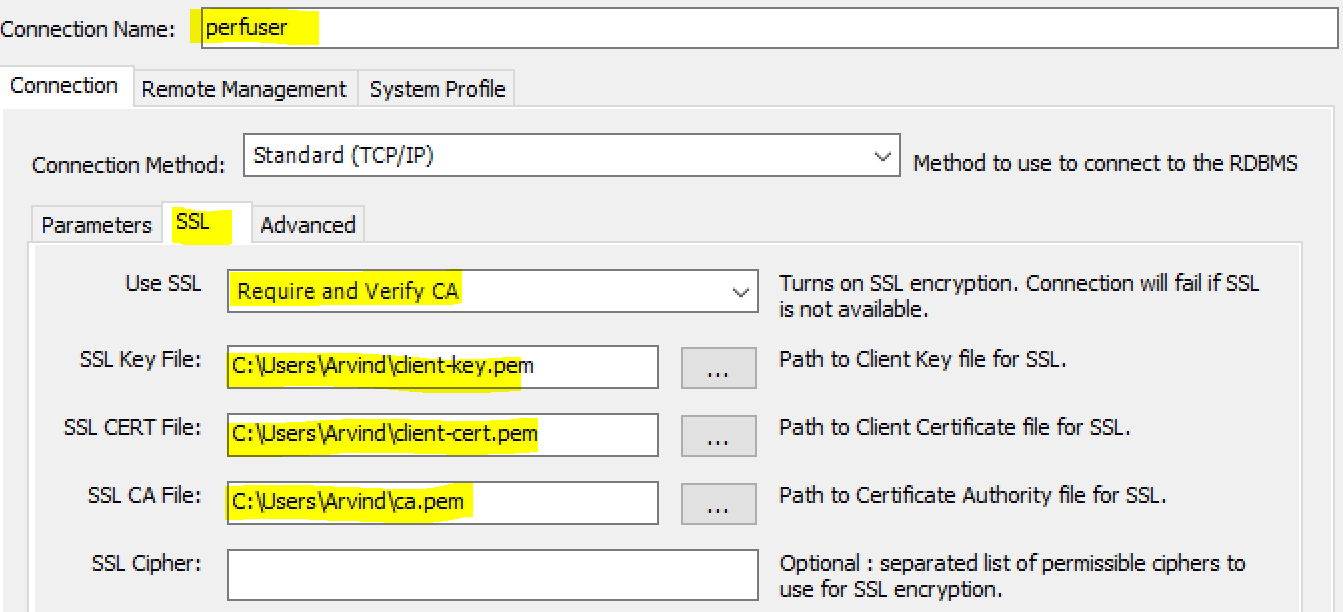

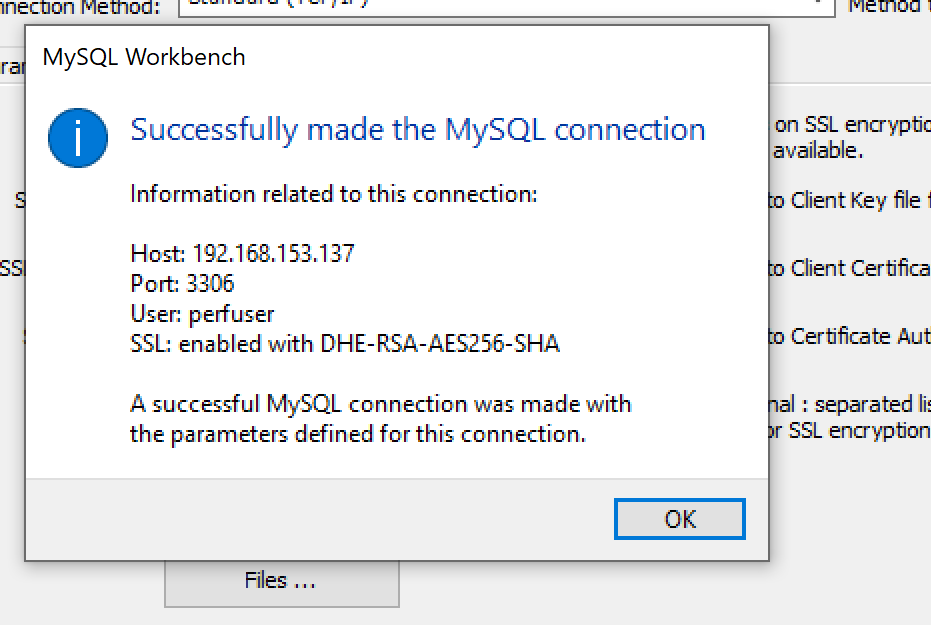

In [ ]:
Try from a linux host
=====================================================

In [ ]:
mysql> create user db_admin identified by 'Dbadmin@2024';
Query OK, 0 rows affected (0.14 sec)

mysql> grant select on *.* to db_admin;
Query OK, 0 rows affected (0.01 sec)

mysql> select user , host , ssl_type , ssl_cipher from mysql.user;
+------------------+-----------+----------+------------------------+
| user             | host      | ssl_type | ssl_cipher             |
+------------------+-----------+----------+------------------------+
| db_admin         | %         |          | 0x                     |
| perfuser         | %         | X509     | 0x                     |
| mysql.infoschema | localhost |          | 0x                     |
| mysql.session    | localhost |          | 0x                     |
| mysql.sys        | localhost |          | 0x                     |
| root             | localhost |          | 0x                     |
+------------------+-----------+----------+------------------------+
6 rows in set (0.00 sec)


[root@bospprod01 ~]# systemctl stop firewalld
[root@bospprod01 ~]# 

[root@bospprod01 ~]# ifconfig | grep 192
        inet 192.168.153.137  netmask 255.255.255.0  broadcast 192.168.153.255
        inet 192.168.122.1  netmask 255.255.255.0  broadcast 192.168.122.255
[root@bospprod01 ~]# 


connect from client ( different host )
==========================================

[mysqluser@mysqlprod02 ~]$ mysql -h 192.168.153.137 -u db_admin -p

Enter password: 

mysql> select @@hostname;
+------------+
| @@hostname |
+------------+
| bospprod01 |
+------------+
1 row in set (0.00 sec)


force user to use ssl 
============================================

[root@bospprod01 ~]# mysql

mysql> alter user db_admin require ssl;
Query OK, 0 rows affected (0.01 sec)

mysql> flush privileges;
Query OK, 0 rows affected (0.00 sec)

mysql> select user , host , ssl_type , ssl_cipher from mysql.user;
+------------------+-----------+----------+------------------------+
| user             | host      | ssl_type | ssl_cipher             |
+------------------+-----------+----------+------------------------+
| db_admin         | %         | ANY      | 0x                     |
| perfuser         | %         | X509     | 0x                     |
| mysql.infoschema | localhost |          | 0x                     |
| mysql.session    | localhost |          | 0x                     |
| mysql.sys        | localhost |          | 0x                     |
| root             | localhost |          | 0x                     |
+------------------+-----------+----------+------------------------+
6 rows in set (0.00 sec)


Again try connecting from client
===================================================

[mysqluser@mysqlprod02 ~]$ mysql -h 192.168.153.137 -u db_admin -p
Enter password: 
mysql> 


mysql> select processlist_id , processlist_user , processlist_host , connection_type from
    -> performance_schema.threads where processlist_id is not null
    -> and processlist_user = 'db_admin';
+----------------+------------------+------------------+-----------------+
| processlist_id | processlist_user | processlist_host | connection_type |
+----------------+------------------+------------------+-----------------+
|             19 | db_admin         | 192.168.153.134  | SSL/TLS         |
+----------------+------------------+------------------+-----------------+
1 row in set (0.01 sec)


[mysqluser@mysqlprod02 ~]$ mysql --ssl-mode=DISABLED -h 192.168.153.137 -u db_admin -p
Enter password: 
ERROR 1045 (28000): Access denied for user 'db_admin'@'192.168.153.134' (using password: YES)
[mysqluser@mysqlprod02 ~]$ 

[mysqluser@mysqlprod02 ~]$ mysql --ssl-mode=PREFERRED -h 192.168.153.137 -u db_admin -p
Enter password: 
mysql> 


force user to use certificate 
==================================================

mysql> alter user db_admin require X509;
Query OK, 0 rows affected (0.01 sec)

mysql> flush privileges;
Query OK, 0 rows affected (0.00 sec)

mysql> select user , host , ssl_type , ssl_cipher from mysql.user;
+------------------+-----------+----------+------------------------+
| user             | host      | ssl_type | ssl_cipher             |
+------------------+-----------+----------+------------------------+
| db_admin         | %         | X509     | 0x                     |
| perfuser         | %         | X509     | 0x                     |
| mysql.infoschema | localhost |          | 0x                     |
| mysql.session    | localhost |          | 0x                     |
| mysql.sys        | localhost |          | 0x                     |
| root             | localhost |          | 0x                     |
+------------------+-----------+----------+------------------------+
6 rows in set (0.01 sec)


Again try connecting from client 
===================================================

[mysqluser@mysqlprod02 ~]$ mysql --ssl-mode=REQUIRED -h 192.168.153.137 -u db_admin -p
Enter password: 
ERROR 1045 (28000): Access denied for user 'db_admin'@'192.168.153.134' (using password: YES)
[mysqluser@mysqlprod02 ~]$ 
[mysqluser@mysqlprod02 ~]$ mysql --ssl-mode=VERIFY_CA -h 192.168.153.137 -u db_admin -p
Enter password: 
ERROR 2026 (HY000): SSL connection error: CA certificate is required if ssl-mode is VERIFY_CA or VERIFY_IDENTITY
[mysqluser@mysqlprod02 ~]$ 


copy client certificate files to client host 
=====================================================

[root@bospprod01 mysql]# pwd
/var/lib/mysql
[root@bospprod01 mysql]# ls -rtl *client*
-rw-r--r--. 1 mysql mysql 1680 May 27 16:46 client-key.pem
-rw-r--r--. 1 mysql mysql 1112 May 27 16:46 client-cert.pem
[root@bospprod01 mysql]# 
[root@bospprod01 mysql]# scp *client* mysqluser@192.168.153.134:/home/mysqluser/
mysqluser@192.168.153.134's password: 
client-cert.pem                               100% 1112   245.1KB/s   00:00    
client-key.pem                                100% 1680   781.1KB/s   00:00 
ca.pem                                        100% 1112   354.0KB/s   00:00    
[root@bospprod01 mysql]# 

   
Again try connecting from client 
===================================================

[mysqluser@mysqlprod02 ~]$ mysql --ssl-mode=VERIFY_CA --ssl-cert=client-cert.pem --ssl-key=client-key.pem 
--ssl-ca=ca.pem -h 192.168.153.137 -u db_admin -p
Enter password: 
mysql> select @@hostname;
+------------+
| @@hostname |
+------------+
| bospprod01 |
+------------+
1 row in set (0.00 sec)


mysql> select t.THREAD_ID,
    ->     t.PROCESSLIST_USER,
    ->     t.PROCESSLIST_HOST,
    ->     t.CONNECTION_TYPE,
    ->     sbt.VARIABLE_VALUE AS cipher
    -> FROM performance_schema.threads t
    -> LEFT JOIN performance_schema.status_by_thread sbt
    ->     ON (t.THREAD_ID = sbt.THREAD_ID AND sbt.VARIABLE_NAME = 'Ssl_cipher')
    -> WHERE t.PROCESSLIST_USER IS NOT NULL;

+-----------+------------------+------------------+-----------------+--------------------+
| THREAD_ID | PROCESSLIST_USER | PROCESSLIST_HOST | CONNECTION_TYPE | cipher             |
+-----------+------------------+------------------+-----------------+--------------------+
|        48 | event_scheduler  | localhost        | NULL            | NULL               |
|        75 | root             | localhost        | Socket          |                    |
|        76 | db_admin         | 192.168.153.134  | SSL/TLS         | DHE-RSA-AES256-SHA |
|        79 | perfuser         | 192.168.153.1    | SSL/TLS         | DHE-RSA-AES256-SHA |
|        80 | perfuser         | 192.168.153.1    | SSL/TLS         | DHE-RSA-AES256-SHA |
+-----------+------------------+------------------+-----------------+--------------------+
5 rows in set (0.00 sec)